In [1]:
import math
import cvxpy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.stats import multivariate_normal as mvn

import importlib
from utils import MPCTrajectory, track_example1
from tqdm import tqdm
from utils.cubic_spline_planner import calc_spline_course
from utils import *

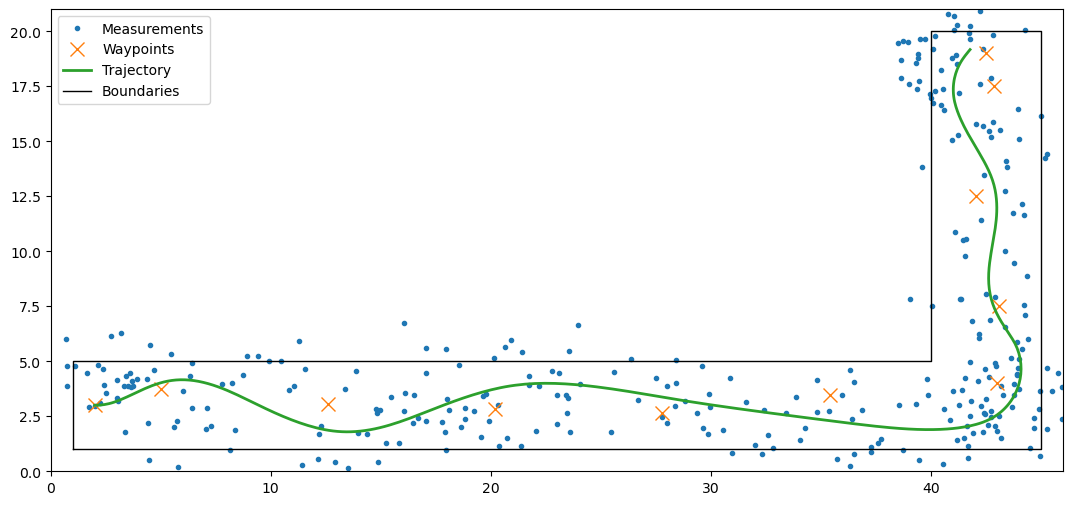

In [2]:
x_points, y_points, line_segments = track_example1()
trajectory = MPCTrajectory(x_points, y_points, line_segments, savepath="output/track_L1.pkl")
states, measurements = trajectory.get_data()

trajectory.plot(states, measurements)

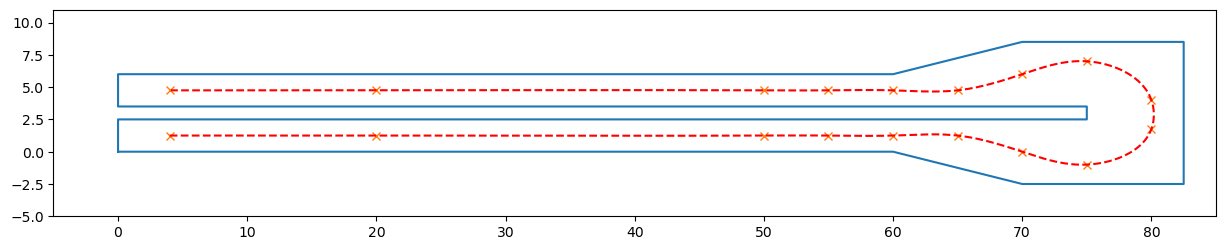

In [195]:
line_segments = np.array([(0, 0), (60, 0), (70, -2.5), (82.5, -2.5), (82.5, 8.5), (70, 8.5), (60, 6), (0, 6), (0, 3.5), (75, 3.5), (75, 2.5), (0, 2.5), (0, 0)])
x_coords_1 = np.array([4, 20, 50, 55, 60, 65, 70, 75, 80])
x_coords_2 = x_coords_1[::-1]
y_coords_1 = np.concatenate([np.repeat(1.25, 6), [0, -1.0, 1.75]])
y_coords_2 = np.concatenate([[4.0, 7.0, 6.0], np.repeat(4.75, 6)])

x_coords = np.concatenate([x_coords_1, x_coords_2])
y_coords = np.concatenate([y_coords_1, y_coords_2])

cx1, cy1, cyaw1, ck1, s1 = calc_spline_course(x_coords_1, y_coords_1, ds=0.2)
cx2, cy2, cyaw2, ck2, s2 = calc_spline_course(x_coords_2, y_coords_2, ds=0.2)

cx = np.concatenate([cx1, cx2])
cy = np.concatenate([cy1, cy2])
cyaw = np.concatenate([cyaw1, cyaw2])
ck = np.concatenate([ck1, ck2])
s = np.concatenate([s1, s2])

cx, cy, cyaw, ck, s = calc_spline_course(x_coords, y_coords, ds=0.2)
cyaw = np.abs(cyaw)

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.set_xlim(-5, 85)
ax.set_ylim(-5, 11)
ax.plot(line_segments[:,0], line_segments[:,1])
ax.plot(x_coords, y_coords, 'x')
ax.set_aspect('equal', 'box')
ax.plot(cx, cy, '--r', label="spline")
plt.show()

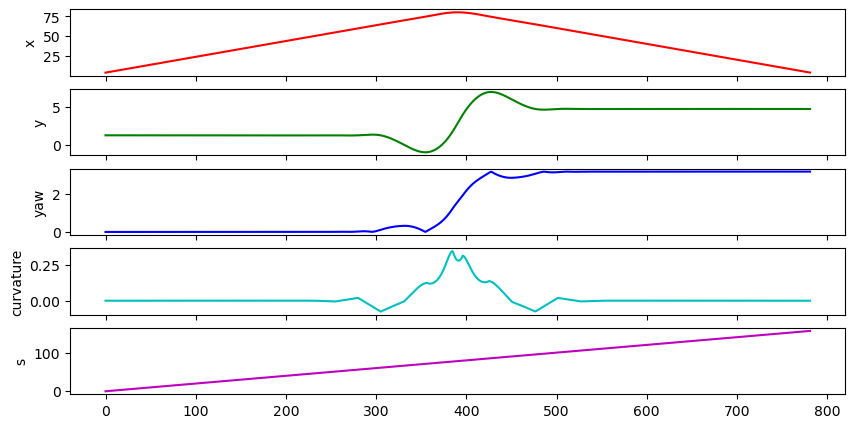

In [196]:
fig, ax = plt.subplots(5, 1, figsize=(10, 5), sharex=True)
ax[0].plot(cx, "-r", label="x")
ax[0].set_ylabel("x")
ax[1].plot(cy, "-g", label="y")
ax[1].set_ylabel("y")
ax[2].plot(cyaw, "-b", label="yaw")
ax[2].set_ylabel("yaw")
ax[3].plot(ck, "-c", label="curvature") 
ax[3].set_ylabel("curvature")
ax[4].plot(s, "-m", label="s")
ax[4].set_ylabel("s")
plt.show()

In [197]:
initial_state = Vehicle(x=cx[0], y=cy[0], yaw=cyaw[0], dt=0.1)
dl = 0.1
        
simulation = Simulation(initial_state, goal_speed=0.01, goal_dist=5.0, target_speed=3, max_time=200)
sp = np.abs(np.array(simulation.calc_speed_profile(cx, cy, cyaw)))


sp = np.abs(np.array(simulation.calc_speed_profile(cx, cy, cyaw)))

speed_reduction = np.diff(cyaw)
speed_reduction = np.concatenate([speed_reduction[int(len(speed_reduction)*0.05):],
                                np.linspace(speed_reduction[-1], 0, int(len(speed_reduction)*0.05))])
speed_reduction = np.convolve(speed_reduction, np.ones(len(sp) // 5)/(len(sp) // 5), mode='same')
speed_reduction = ((1.5*np.max(np.abs(speed_reduction)) - np.abs(speed_reduction)) / (1.5*np.max(np.abs(speed_reduction))))
speed_reduction = np.clip(speed_reduction, 0, 1)
speed_reduction *= np.concatenate([np.ones(int(len(speed_reduction)*0.95)+1), np.linspace(1, 0, int(len(speed_reduction)*0.05))])
sp[:-1] *= speed_reduction

#sp = trajectory.speed_reduction(cyaw, sp)

# Simulation
states_hist, controls_hist = simulation.simulate(cx, cy, cyaw, ck, dl, sp = sp)

# Get simulation states
x, y, v, yaw = states_hist['x'], states_hist['y'], states_hist['v'], states_hist['yaw']  
t = states_hist['t']
d = controls_hist['d']
target_inds = controls_hist['target_inds']

MPC: 0it [00:00, ?it/s]

Goal


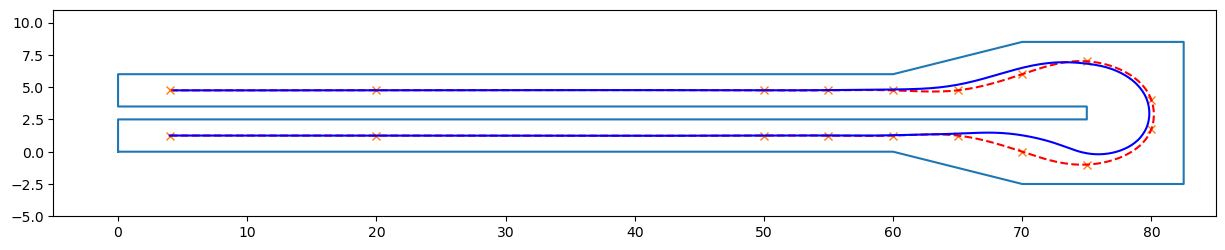

In [198]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.set_xlim(-5, 85)
ax.set_ylim(-5, 11)
ax.plot(line_segments[:,0], line_segments[:,1])
ax.plot(x_coords, y_coords, 'x')
ax.set_aspect('equal', 'box')
ax.plot(cx, cy, '--r', label="spline")
ax.plot(x, y, '-b', label="trajectory")
plt.show()

In [199]:
filename = "animation_long"

fig, ax = plt.subplots(1, 1, figsize=(16, 6))
        
target_inds = controls_hist['target_inds'] 
t = states_hist['t']
v = states_hist['v']
yaw = states_hist['yaw']
d = controls_hist['d']

def aux_animate(i):
    i = 2*i
    ax.cla()
    ax.plot(x_coords, y_coords, "kx", markersize=10)
    ax.plot(x[:i], y[:i], "-r", label="trajectory")
    #ax.plot(measurements[:i, 0], measurements[:i, 1], 'bx', markersize=3, label="measurements")
    ax.plot(cx[target_inds[i]], cy[target_inds[i]], "xg", label="target")

    plot_car(ax, x[i], y[i], yaw[i], steer=d[i])

    ax.axis("equal")
    ax.grid(True)

    ax.set_title("Time [s]:" + str(round(t[i], 2)) + ", speed [km/h]:" + str(round(v[i] * 3.6, 2)))

    ax.set_xlim(-5, 85)
    ax.set_ylim(-5, 11)
    ax.plot(line_segments[:,0], line_segments[:,1])
    ax.plot(x_coords, y_coords, 'x')
    ax.set_aspect('equal', 'box')

ani = animation.FuncAnimation(fig, aux_animate, frames=len(t)//2, repeat=False)

# Save animation with progress bar
with tqdm(total=len(t)//2) as pbar:
    ani.save(f'{filename}.gif', writer='Pillow', fps=25, progress_callback=lambda i, n: pbar.update())
    
plt.close()

  0%|          | 0/330 [00:00<?, ?it/s]

MovieWriter Pillow unavailable; using Pillow instead.


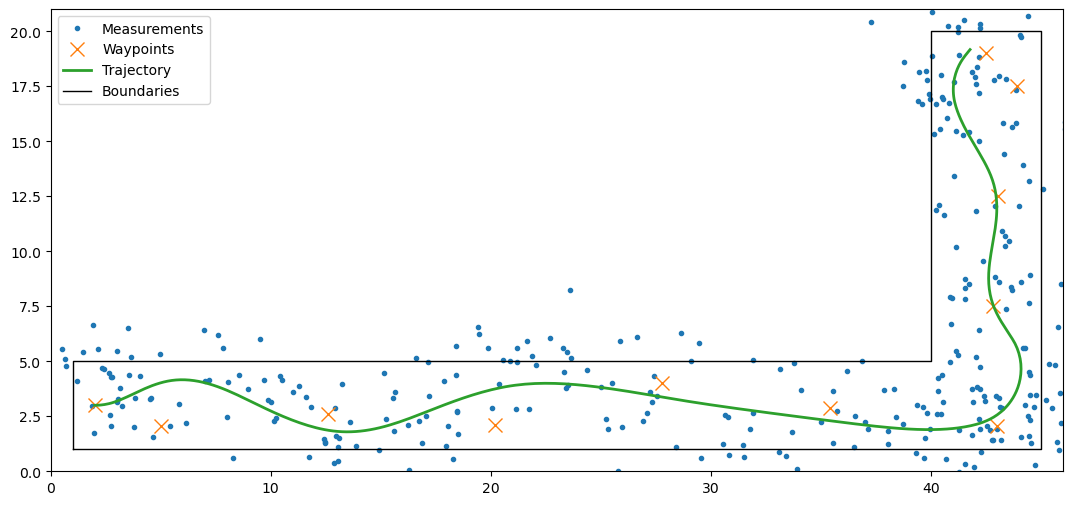